# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [ ]:
import os
import sqlite3
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from datetime import datetime

/tmp/ipykernel_4231/3540646135.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(str(soup))
/tmp/ipykernel_4231/3540646135.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["streams"] = pd.to_numeric(df["streams"].astype(str).str.replace("[^0-9.]", "", regex=True), errors="coerce")


Columnas originales: ['Rank', 'Song', 'Artist(s)', 'Streams (billions)', 'Release date', 'Ref.']


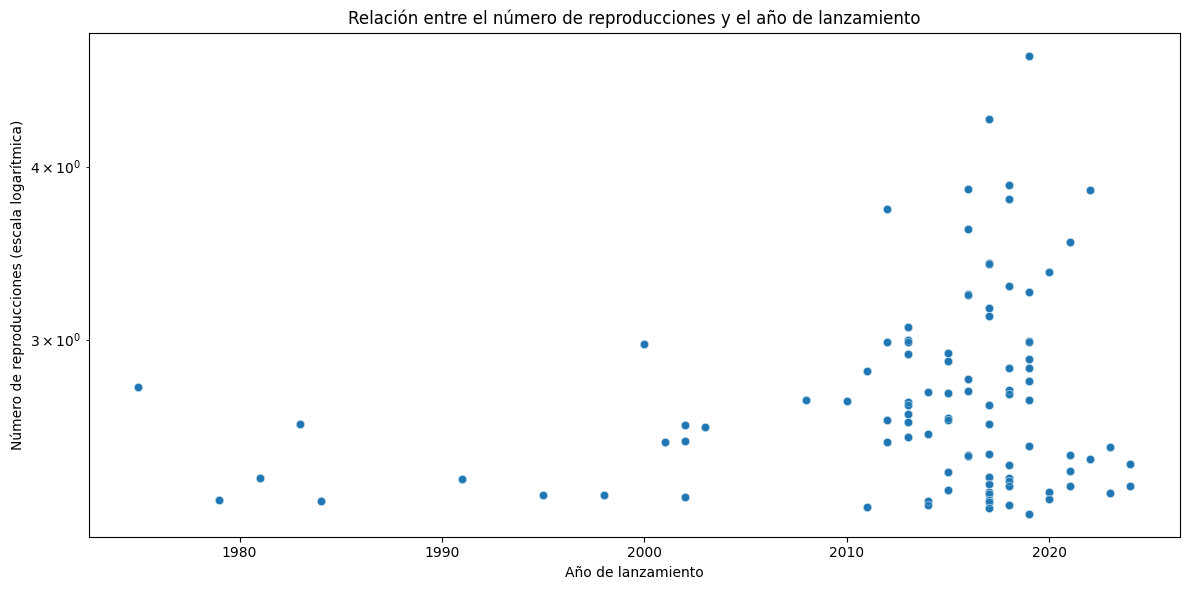

/tmp/ipykernel_4231/3540646135.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_db, x="release_year", order=sorted(df_db["release_year"].dropna().unique()), palette="magma")


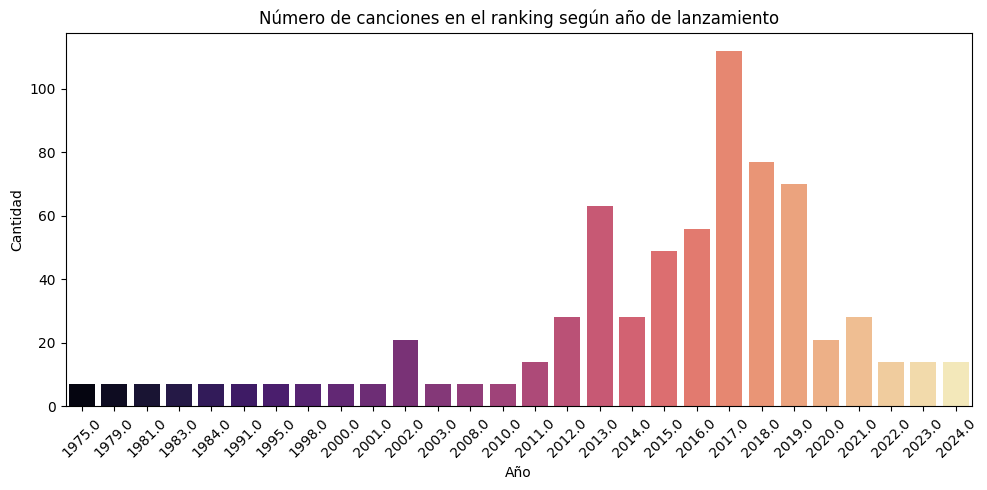

/tmp/ipykernel_4231/3540646135.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=artists.values, y=artists.index, palette="magma")


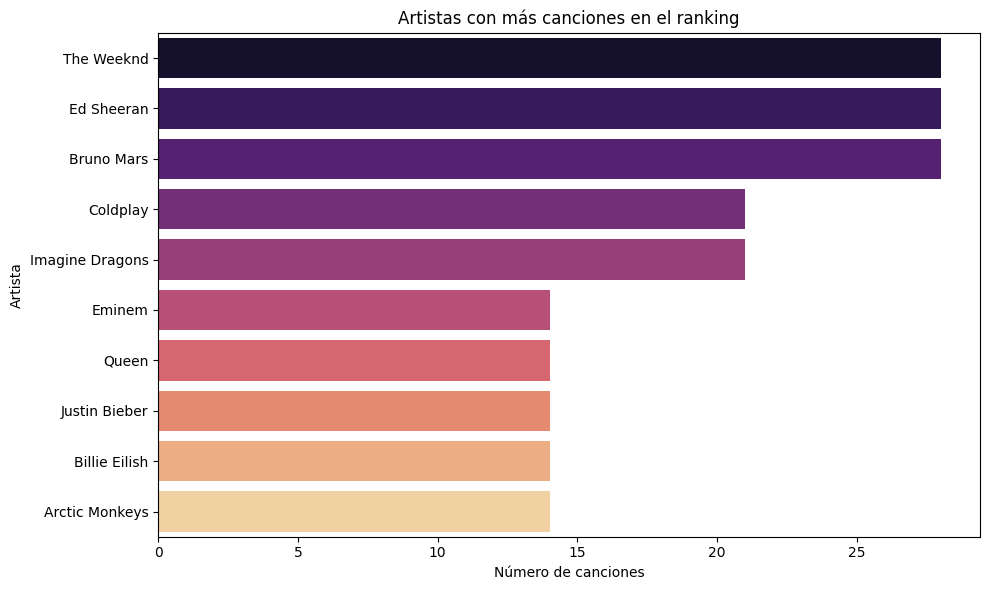

In [ ]:

# Paso 1: Descargar HTML
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
response = requests.get(url)

if response.status_code == 200:
    html = response.text

    # Paso 2: Analizar HTML con BeautifulSoup
    soup = BeautifulSoup(html, "html.parser")

    # Paso 3: Extraer la tabla con pandas
    tables = pd.read_html(str(soup))
    df = tables[0]  # Se asume que la primera tabla es la correcta

    # Imprimir columnas originales para verificar estructura
    print("Columnas originales:", df.columns.tolist())

    # Si hay más columnas de las esperadas, eliminar las innecesarias
    if df.shape[1] > 5:
        df = df.iloc[:, :5]  # Solo conservar las primeras 5 columnas

    # Renombrar columnas
    df.columns = ["rank", "song", "artist", "streams", "release_date"]

    # Paso 4: Limpiar el DataFrame
    df["streams"] = pd.to_numeric(df["streams"].astype(str).str.replace("[^0-9.]", "", regex=True), errors="coerce")
    df["release_year"] = pd.to_datetime(df["release_date"], errors="coerce").dt.year

    # Agregar la fecha de scraping con el nombre correcto
    df["scraping_date"] = datetime.now().strftime("%Y-%m-%d")

    # Paso 5: Almacenar en SQLite
    conn = sqlite3.connect("spotify_songs.db")
    cursor = conn.cursor()

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS daily_rankings (
            scraping_date TEXT,
            rank INTEGER,
            song TEXT,
            artist TEXT,
            streams REAL,
            release_year INTEGER
        )
    ''')

    df_daily = df[["scraping_date", "rank", "song", "artist", "streams", "release_year"]]
    df_daily.to_sql("daily_rankings", conn, if_exists="append", index=False)

    conn.commit()
    conn.close()

    # Paso 6: Graficar los datos

    # Conectar y leer datos históricos
    conn = sqlite3.connect("spotify_songs.db")
    df_db = pd.read_sql("SELECT * FROM daily_rankings", conn)
    conn.close()

    # Asegurar que la columna scraping_date sea de tipo datetime
    df_db["scraping_date"] = pd.to_datetime(df_db["scraping_date"])

    # Gráfico 1: Relación entre el número de reproducciones y el año de lanzamiento
    if not df_db.empty:
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=df_db, x="release_year", y="streams", alpha=0.5)
        plt.xscale("linear")
        plt.yscale("log")
        plt.title("Relación entre el número de reproducciones y el año de lanzamiento")
        plt.xlabel("Año de lanzamiento")
        plt.ylabel("Número de reproducciones (escala logarítmica)")
        plt.tight_layout()
        plt.show()
    else:
        print("No hay datos suficientes para generar el gráfico 1.")

    # Gráfico 2: Número de canciones por año de lanzamiento
    if not df_db.empty:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df_db, x="release_year", order=sorted(df_db["release_year"].dropna().unique()), palette="magma")
        plt.title("Número de canciones en el ranking según año de lanzamiento")
        plt.xlabel("Año")
        plt.ylabel("Cantidad")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No hay datos suficientes para generar el gráfico 2.")

    # Gráfico 3: Artistas con más canciones en el ranking
    if not df_db.empty:
        artists = df_db["artist"].value_counts().nlargest(10)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=artists.values, y=artists.index, palette="magma")
        plt.title("Artistas con más canciones en el ranking")
        plt.xlabel("Número de canciones")
        plt.ylabel("Artista")
        plt.tight_layout()
        plt.show()
    else:
        print("No hay datos suficientes para generar el gráfico 3.")

else:
    print("Error al descargar la página:", response.status_code)